# **Bus Line Analysis: Optimization and Scenarios**
**Author**: Maxime Delplanque  
**Objective**: Analyze and optimize bus lines using demand and network data, employing routing methods and comparative scenarios.  

---
## **Table of Contents**
- [1. Import Libraries](#1-import-libraries)
- [2. Load Data](#2-load-data)
- [3. Data Preprocessing](#3-data-preprocessing)
- [4. Data Consistency Verification](#4-data-consistency-verification)
- [5. Utility Functions](#5-utility-functions)
- [6. Origin-Destination (OD) Pair Analysis](#6-origin-destination-od-pair-analysis)
- [7. Bus Corridor Creation](#7-bus-corridor-creation)
- [8. Line Ridership Calculation](#8-line-ridership-calculation)
- [9. Bus Line Scenarios](#9-bus-line-scenarios)
- [10. Scenario Visualization](#10-scenario-visualization)
- [11. Custom Network](#11-custom-network)
- [12. Detailed Network Analysis](#12-detailed-network-analysis)

### **1. Import Libraries**
**Objective**: Import necessary libraries for data processing, network modeling, and visualization.


In [18]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import LineString, Point, Polygon, MultiLineString, box
from shapely.ops import linemerge
import matplotlib.gridspec as gridspec
import math
from sklearn.cluster import KMeans
import itertools

# Initial configuration for reproducibility
np.random.seed(42)
print("✅ Libraries imported successfully.")

✅ Libraries imported successfully.


---
### **2. Load Data**
**Objective**: Load node, link, and demand data from CSV files and display a summary.

In [19]:
# Load data
df_demand = pd.read_csv('../data_preprocessed/demand.csv')
df_link = pd.read_csv('../data_preprocessed/link.csv')
df_node = pd.read_csv('../data_preprocessed/node.csv')
df_settings = pd.read_csv('../data/settings.csv')

# Data summary
print("=" * 80)
print("LOADED DATA SUMMARY")
print("=" * 80)
print(f"➡ Nodes: {len(df_node):,} records")
print(f"➡ Links: {len(df_link):,} records")
print(f"➡ Demand: {len(df_demand):,} Origin-Destination (OD) pairs")
print("✅ Data loaded successfully.")

LOADED DATA SUMMARY
➡ Nodes: 8,521 records
➡ Links: 28,788 records
➡ Demand: 30,422 Origin-Destination (OD) pairs
✅ Data loaded successfully.


---
### **3. Data Preprocessing**
**Objective**: Convert geometries to GeoDataFrame objects and create a network graph for analysis.

In [20]:
# Function to parse geometries
def parse_geometry(geom):
    if isinstance(geom, Point):
        return geom
    if isinstance(geom, str):
        try:
            return wkt.loads(geom)
        except:
            raise ValueError(f"Error: Unable to parse geometry: {geom}")
    return geom

# Convert nodes and links to GeoDataFrame
nodes_gdf = gpd.GeoDataFrame(
    df_node,
    geometry=df_node['geometry'].apply(parse_geometry),
    crs='EPSG:4326'
)
print(f"✅ Nodes converted to GeoDataFrame: {len(nodes_gdf)} nodes")

links_gdf = gpd.GeoDataFrame(
    df_link,
    geometry=df_link['geometry'].apply(parse_geometry),
    crs='EPSG:4326'
)
print(f"✅ Links converted to GeoDataFrame: {len(links_gdf)} links")

# Create network graph
G = nx.DiGraph()
for _, row in df_node.iterrows():
    G.add_node(
        row['node_id'],
        zone_id=row.get('zone_id'),
        x_coord=row['x_coord'],
        y_coord=row['y_coord']
    )

for _, row in df_link.iterrows():
    G.add_edge(
        row['from_node_id'],
        row['to_node_id'],
        link_id=row['link_id'],
        length=row['length'],
        free_speed=row['free_speed'],
        lanes=row['lanes'],
        capacity=row['capacity'],
        link_type=row.get('link_type')
    )

print(f"✅ Network graph created: {G.number_of_nodes():,} nodes and {G.number_of_edges():,} links.")

# Create zone points (centroids)
zone_points = (
    nodes_gdf.dropna(subset=['zone_id'])
    .groupby('zone_id')['geometry']
    .apply(lambda g: g.unary_union.centroid)
    .reset_index()
    .rename(columns={'geometry': 'geometry'})
)
zone_points_gdf = gpd.GeoDataFrame(zone_points, geometry='geometry', crs='EPSG:4326')
print(f"✅ Zone points created: {len(zone_points_gdf)} zones.")


✅ Nodes converted to GeoDataFrame: 8521 nodes
✅ Links converted to GeoDataFrame: 28788 links
✅ Network graph created: 8,521 nodes and 28,788 links.
✅ Zone points created: 235 zones.


C:\Users\maxde\AppData\Local\Temp\ipykernel_3476\2597969323.py:55: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  .apply(lambda g: g.unary_union.centroid)


---
### **4. Data Consistency Verification**
**Objective**: Verify that nodes, zones, and links are consistent between DataFrames and the graph.

In [21]:
# Node verification
nodes_in_gdf = set(nodes_gdf['node_id'])
nodes_in_G = set(G.nodes())

print("=" * 60)
print("NODE VERIFICATION")
print("=" * 60)
print(f"➡ Nodes in nodes_gdf: {len(nodes_in_gdf)}")
print(f"➡ Nodes in graph G: {len(nodes_in_G)}")

if nodes_in_gdf != nodes_in_G:
    print("⚠️ Inconsistency detected between nodes_gdf and graph G.")
else:
    print("✅ Consistency verified: all nodes are present.")

# Zone verification
zones_in_zone_points = set(zone_points_gdf['zone_id'])
zones_in_demand = set(df_demand['o_zone_id']).union(set(df_demand['d_zone_id']))

print("\n" + "=" * 60)
print("ZONE VERIFICATION")
print("=" * 60)
print(f"➡ Zones in zone_points_gdf: {len(zones_in_zone_points)}")
print(f"➡ Zones in df_demand: {len(zones_in_demand)}")

if zones_in_demand.issubset(zones_in_zone_points):
    print("✅ All zones in df_demand are present in zone_points_gdf.")
else:
    missing_zones = zones_in_demand - zones_in_zone_points
    print(f"⚠️ Missing zones in zone_points_gdf: {missing_zones}")

# Link verification
print("\n" + "=" * 60)
print("LINK VERIFICATION")
print("=" * 60)
print(f"➡ Links in df_link: {len(df_link)}")
print(f"➡ Links in graph G: {len(G.edges())}")

if len(df_link) == len(G.edges()):
    print("✅ Consistency verified: all links are present.")
else:
    print("⚠️ Inconsistency detected between df_link and graph G.")


NODE VERIFICATION
➡ Nodes in nodes_gdf: 8521
➡ Nodes in graph G: 8521
✅ Consistency verified: all nodes are present.

ZONE VERIFICATION
➡ Zones in zone_points_gdf: 235
➡ Zones in df_demand: 234
✅ All zones in df_demand are present in zone_points_gdf.

LINK VERIFICATION
➡ Links in df_link: 28788
➡ Links in graph G: 28788
✅ Consistency verified: all links are present.


---
### **5. Utility Functions**
**Objective**: Define reusable functions for distance calculations, travel time, and corridor similarity.


In [22]:
def nearest_node(point_wgs84, nodes_gdf_proj):
    """Find the nearest node to a given point."""
    pt_proj = gpd.GeoSeries([point_wgs84], crs='EPSG:4326').to_crs(3857).iloc[0]
    dists = nodes_gdf_proj.geometry.distance(pt_proj)
    nearest_idx = dists.idxmin()
    return nodes_gdf.loc[nearest_idx, 'node_id']

def edge_time(u, v, data):
    """Calculate the travel time of a link."""
    length = data.get('length', 1)
    free_speed = data.get('free_speed', 1)
    return length / (free_speed if free_speed > 0 else 1e-3)

def jaccard(a, b):
    """Calculate the Jaccard similarity between two sets."""
    intersection = len(a & b)
    union = len(a | b) if (a | b) else 1
    return intersection / union

def calculate_path_length(G, path_nodes):
    """Calculate the total length of a path."""
    return sum(G[u][v].get('length', 0) for u, v in zip(path_nodes[:-1], path_nodes[1:]))

def line_and_stops_from_path(path_nodes, nodes_gdf, stop_spacing_m):
    """Generate a line and stops from a path."""
    pts = [nodes_gdf.loc[nodes_gdf['node_id'] == n, 'geometry'].iloc[0] for n in path_nodes]
    line_geom = LineString(pts)
    line_proj = gpd.GeoSeries([line_geom], crs='EPSG:4326').to_crs(3857).iloc[0]
    total_length_m = line_proj.length
    n_stops = max(2, int(total_length_m // stop_spacing_m) + 1)
    stops = [line_geom.interpolate(i / (n_stops - 1), normalized=True) for i in range(n_stops)]
    stops_gs = gpd.GeoSeries(stops, crs='EPSG:4326')
    return line_geom, stops_gs, total_length_m

---
### **6. Origin-Destination (OD) Pair Analysis**
**Objective**: Identify the most demanded OD pairs and visualize their spatial distribution.

C:\Users\maxde\AppData\Local\Temp\ipykernel_3476\2940380861.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  .apply(lambda g: g.unary_union.centroid)


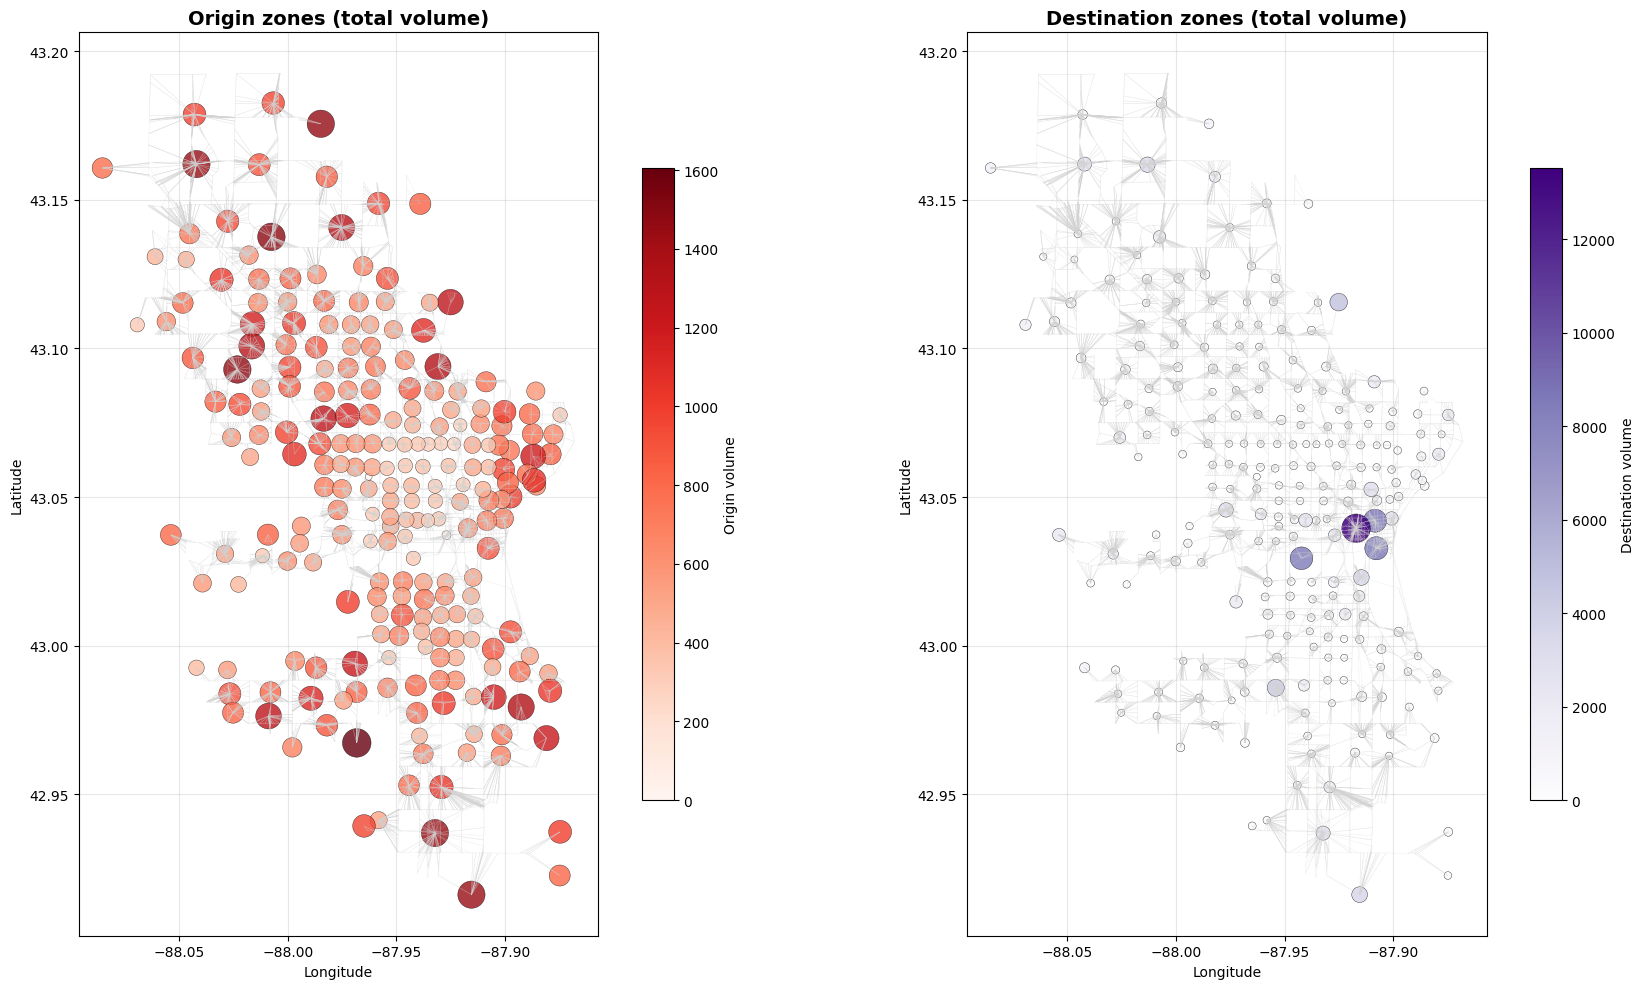

✅ Origin and destination zone maps generated.

TOP 20 OD PAIRS BY VOLUME
 1. Zone   7 → Zone  67 | Volume:        202
 2. Zone  48 → Zone  49 | Volume:        181
 3. Zone 220 → Zone  67 | Volume:        161
 4. Zone  49 → Zone  48 | Volume:        156
 5. Zone 139 → Zone  67 | Volume:        153
 6. Zone  14 → Zone  49 | Volume:        153
 7. Zone  47 → Zone  49 | Volume:        152
 8. Zone  19 → Zone  49 | Volume:        149
 9. Zone 190 → Zone  67 | Volume:        148
10. Zone  67 → Zone  49 | Volume:        146
11. Zone 206 → Zone  67 | Volume:        137
12. Zone  82 → Zone  41 | Volume:        136
13. Zone  46 → Zone  49 | Volume:        135
14. Zone  10 → Zone  49 | Volume:        134
15. Zone 193 → Zone  67 | Volume:        124
16. Zone   9 → Zone  49 | Volume:        123
17. Zone   2 → Zone  49 | Volume:        123
18. Zone  10 → Zone  48 | Volume:        121
19. Zone  82 → Zone  67 | Volume:        120
20. Zone  10 → Zone  67 | Volume:        120


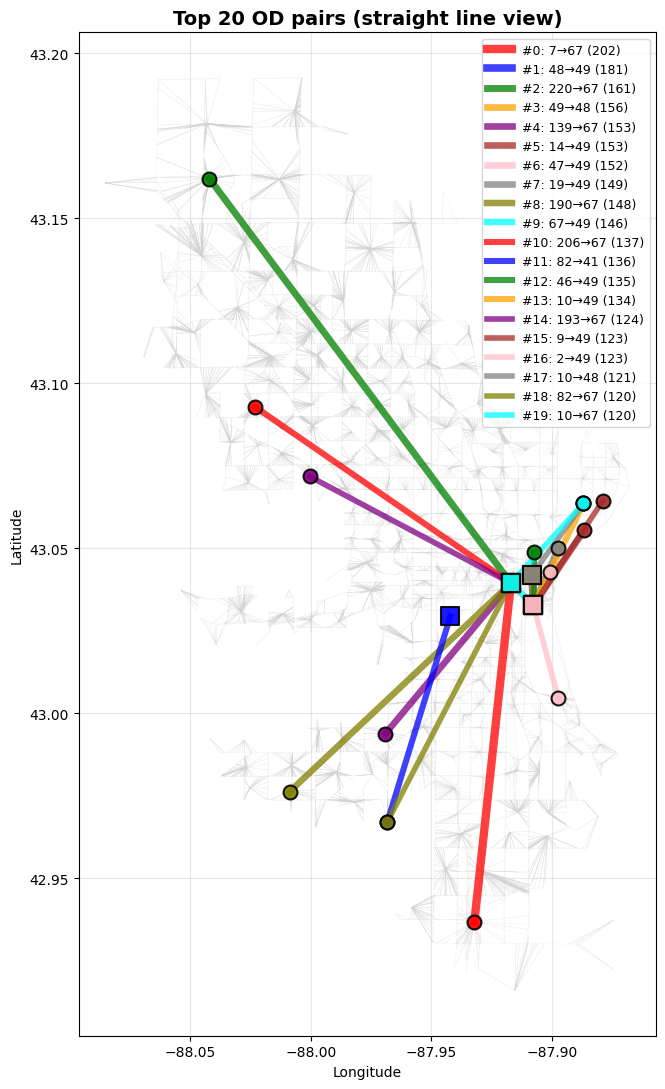

In [ ]:
# Calculate origin and destination volumes
origin_volume = df_demand.groupby('o_zone_id')['volume'].sum().rename('origin_volume')
destination_volume = df_demand.groupby('d_zone_id')['volume'].sum().rename('destination_volume')

# Create zone points
zone_points = (
    nodes_gdf.dropna(subset=['zone_id'])
    .groupby('zone_id')['geometry']
    .apply(lambda g: g.unary_union.centroid)
    .reset_index()
    .rename(columns={'geometry': 'geometry'})
)
zone_points_gdf = gpd.GeoDataFrame(zone_points, geometry='geometry', crs='EPSG:4326')

# Merge with volumes
zone_points_gdf = zone_points_gdf.merge(
    origin_volume, left_on='zone_id', right_index=True, how='left'
).merge(
    destination_volume, left_on='zone_id', right_index=True, how='left'
)
zone_points_gdf[['origin_volume', 'destination_volume']] = zone_points_gdf[['origin_volume', 'destination_volume']].fillna(0)

# Visualize origin and destination zones
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Origin zone map
links_gdf.plot(ax=axes[0], color='lightgray', linewidth=0.3, alpha=0.4)
zone_points_gdf.plot(
    ax=axes[0],
    column='origin_volume',
    cmap='Reds',
    markersize=25 + 400 * zone_points_gdf['origin_volume'] / zone_points_gdf['origin_volume'].max(),
    alpha=0.8,
    edgecolor='black',
    linewidth=0.3,
    legend=True,
    legend_kwds={'label': 'Origin volume', 'shrink': 0.7}
)
axes[0].set_title('Origin zones (total volume)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].grid(True, alpha=0.3)

# Destination zone map
links_gdf.plot(ax=axes[1], color='lightgray', linewidth=0.3, alpha=0.4)
zone_points_gdf.plot(
    ax=axes[1],
    column='destination_volume',
    cmap='Purples',
    markersize=25 + 400 * zone_points_gdf['destination_volume'] / zone_points_gdf['destination_volume'].max(),
    alpha=0.85,
    edgecolor='black',
    linewidth=0.3,
    legend=True,
    legend_kwds={'label': 'Destination volume', 'shrink': 0.7}
)
axes[1].set_title('Destination zones (total volume)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/bus/zone_maps.png', dpi=300)
plt.show()
print("✅ Origin and destination zone maps generated.")

# Top 20 OD pairs by volume
nbr_top_corridors = 20
od_top = (
    df_demand.groupby(['o_zone_id', 'd_zone_id'])['volume']
    .sum()
    .reset_index()
    .sort_values('volume', ascending=False)
    .head(nbr_top_corridors)
)

print("\n" + "=" * 80)
print(f"TOP {nbr_top_corridors} OD PAIRS BY VOLUME")
print("=" * 80)
for idx, (_, row) in enumerate(od_top.iterrows(), 1):
    print(f"{idx:2d}. Zone {int(row['o_zone_id']):3d} → Zone {int(row['d_zone_id']):3d} | Volume: {row['volume']:>10,.0f}")

# Visualize OD pairs
fig, ax = plt.subplots(figsize=(14, 11))
links_gdf.plot(ax=ax, color='lightgray', linewidth=0.3, alpha=0.3, edgecolor='gray')
zone_lookup = zone_points_gdf.set_index('zone_id')

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for idx, (_, row) in enumerate(od_top.iterrows()):
    o_zone, d_zone = int(row['o_zone_id']), int(row['d_zone_id'])
    vol = row['volume']

    if o_zone in zone_lookup.index and d_zone in zone_lookup.index:
        o_pt = zone_lookup.loc[o_zone, 'geometry']
        d_pt = zone_lookup.loc[d_zone, 'geometry']

        line_width = 1 + 5 * (vol / od_top['volume'].max())
        ax.plot(
            [o_pt.x, d_pt.x], [o_pt.y, d_pt.y],
            color=colors[idx % len(colors)],
            linewidth=line_width,
            alpha=0.75,
            label=f"#{idx}: {o_zone}→{d_zone} ({vol:,.0f})"
        )

        ax.scatter([o_pt.x], [o_pt.y], color=colors[idx % len(colors)], s=100, marker='o',
                  edgecolor='black', linewidth=1.5, zorder=5, alpha=0.9)
        ax.scatter([d_pt.x], [d_pt.y], color=colors[idx % len(colors)], s=150, marker='s',
                  edgecolor='black', linewidth=1.5, zorder=5, alpha=0.9)

ax.set_title(f'Top {nbr_top_corridors} OD pairs (straight line view)', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=9)
plt.tight_layout()
plt.savefig('../results/bus/top_od_pairs.png', dpi=300)
plt.show()


---
### **7. Bus Corridor Creation**
**Objective**: Generate bus corridors based on catchment area demand around zones.

In [24]:
# Parameters
catchment_radius_m = 500
stop_spacing_m = 600
overlap_jaccard_max = 1

# Calculate catchment area demand
def get_catchment_demand(zone_id, direction='origin', radius_m=catchment_radius_m):
    zone_centroid = zone_points_gdf.set_index('zone_id').loc[zone_id, 'geometry']
    nodes_proj = nodes_gdf.to_crs(3857)
    distances = nodes_proj.geometry.distance(zone_centroid)
    catchment_nodes = nodes_proj[distances <= radius_m]['node_id'].tolist()
    catchment_zones = df_node[df_node['node_id'].isin(catchment_nodes)]['zone_id'].unique()

    if direction == 'origin':
        return df_demand[df_demand['o_zone_id'].isin(catchment_zones)]['volume'].sum()
    else:
        return df_demand[df_demand['d_zone_id'].isin(catchment_zones)]['volume'].sum()

# Add catchment demand to OD pairs
od_top['catchment_demand'] = od_top.apply(
    lambda row: get_catchment_demand(row['o_zone_id'], 'origin') +
                get_catchment_demand(row['d_zone_id'], 'destination'),
    axis=1
)
od_top_catchment = od_top.sort_values('catchment_demand', ascending=False).head(nbr_top_corridors)

# Create corridors
corridors_catchment = []
kept_corridors = 0
nodes_proj = nodes_gdf.to_crs(3857)
G_working = G.copy()

for _, row in od_top_catchment.iterrows():
    if kept_corridors >= nbr_top_corridors:
        break

    o_zone, d_zone = int(row['o_zone_id']), int(row['d_zone_id'])
    o_pt = zone_points_gdf.set_index('zone_id').loc[o_zone, 'geometry']
    d_pt = zone_points_gdf.set_index('zone_id').loc[d_zone, 'geometry']

    source_node = nearest_node(o_pt, nodes_proj)
    target_node = nearest_node(d_pt, nodes_proj)

    try:
        path_nodes = nx.shortest_path(G_working, source=source_node, target=target_node, weight='length')
    except nx.NetworkXNoPath:
        continue

    line_geom, stops, length_m = line_and_stops_from_path(path_nodes, nodes_gdf, stop_spacing_m)
    path_set = set(path_nodes)

    if any(jaccard(path_set, c['path_set']) > overlap_jaccard_max for c in corridors_catchment):
        continue

    total_time_h = sum(edge_time(u, v, G.get_edge_data(u, v)) for u, v in zip(path_nodes[:-1], path_nodes[1:]))

    corridors_catchment.append({
        'o_zone': o_zone,
        'd_zone': d_zone,
        'direct_volume': row['volume'],
        'catchment_volume': row['catchment_demand'],
        'geometry': line_geom,
        'stops': stops,
        'length_m': length_m,
        'time_min': total_time_h * 60,
        'path_set': path_set,
    })
    kept_corridors += 1

print(f"✅ {len(corridors_catchment)} corridors created based on catchment area demand.")


✅ 8 corridors created based on catchment area demand.


---
### **8. Line Ridership Calculation**
**Objective**: Calculate total ridership for each corridor considering served zones.


In [25]:
def calculate_line_ridership(corridor, stop_radius_m=400):
    """Calculate total ridership for a bus line."""
    stops_proj = gpd.GeoSeries(corridor['stops'], crs='EPSG:4326').to_crs(3857)
    served_zones = set()

    for stop in stops_proj:
        distances = nodes_gdf.to_crs(3857).geometry.distance(stop)
        nearby_nodes = nodes_gdf[distances <= stop_radius_m]['node_id'].tolist()
        nearby_zones = nodes_gdf[nodes_gdf['node_id'].isin(nearby_nodes)]['zone_id'].dropna().unique()
        served_zones.update(nearby_zones)

    od_demand = df_demand[
        (df_demand['o_zone_id'].isin(served_zones)) &
        (df_demand['d_zone_id'].isin(served_zones))
    ]
    return od_demand['volume'].sum()

for corridor in corridors_catchment:
    corridor['total_ridership'] = calculate_line_ridership(corridor)

---
### **9. Bus Line Scenarios**
**Objective**: Create different bus line scenarios (Dijkstra, K-Shortest Paths, A*, Clustering).


In [ ]:
# Function to plot a scenario
def plot_scenario(corridors, title):
    fig = plt.figure(figsize=(18, 14))
    ax = fig.add_subplot(111)
    links_gdf.plot(ax=ax, color='lightgray', linewidth=0.5, alpha=0.3, zorder=1)
    nodes_gdf.plot(ax=ax, color='lightgray', markersize=5, alpha=0.3, zorder=2)
    colors = plt.cm.tab20(np.linspace(0, 1, len(corridors)))

    for i, (corr, color) in enumerate(zip(corridors, colors), start=1):
        line_gdf = gpd.GeoDataFrame([{'geometry': corr['geometry']}], crs='EPSG:4326')
        stops_gdf = gpd.GeoDataFrame(geometry=corr['stops'], crs='EPSG:4326')

        line_gdf.plot(ax=ax, color='white', linewidth=5, alpha=0.8, zorder=4)
        line_gdf.plot(ax=ax, color=color, linewidth=3, alpha=0.95, zorder=5)
        stops_gdf.plot(ax=ax, color=color, markersize=70, alpha=0.95,
                      edgecolor='white', linewidth=1.6, marker='o', zorder=6)

        first_stop = corr['stops'].iloc[0]
        last_stop = corr['stops'].iloc[-1]
        ax.scatter([first_stop.x], [first_stop.y], s=180, marker='s', color=color,
                  edgecolor='black', linewidth=2, zorder=7)
        ax.scatter([last_stop.x], [last_stop.y], s=180, marker='^', color=color,
                  edgecolor='black', linewidth=2, zorder=7)

        mid_stop = corr['stops'].iloc[len(corr['stops']) // 2]
        ax.annotate(f'{i}', xy=(mid_stop.x, mid_stop.y), xytext=(0, 0), textcoords='offset points',
                   fontsize=11, fontweight='bold',
                   bbox=dict(boxstyle='circle,pad=0.3', facecolor=color, alpha=0.95,
                             edgecolor='black', linewidth=1.5),
                   color='white', ha='center', va='center', zorder=8)

    ax.set_title(title, fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig(f'../results/bus/{title.lower().replace(" ", "_")}.png', dpi=300)
    plt.show()

# K-Shortest Paths scenario
def create_lines_k_shortest_paths(top_corridors, G, nodes_lookup, stop_spacing_m, kth=2):
    out = []
    for c in top_corridors:
        o_zone, d_zone = c['o_zone'], c['d_zone']
        O = nodes_lookup[nodes_lookup['zone_id'] == o_zone]
        D = nodes_lookup[nodes_lookup['zone_id'] == d_zone]
        if O.empty or D.empty:
            continue

        s, t = O.iloc[0]['node_id'], D.iloc[0]['node_id']
        try:
            gen = nx.shortest_simple_paths(G, s, t, weight='length')
            k_paths = list(itertools.islice(gen, kth))
            if not k_paths:
                continue

            path_nodes = k_paths[-1]
            line_geom, stops, length_m = line_and_stops_from_path(path_nodes, nodes_lookup, stop_spacing_m)
            out.append({
                'o_zone': o_zone,
                'd_zone': d_zone,
                'direct_volume': c.get('direct_volume', 0),
                'catchment_volume': c.get('catchment_volume', 0),
                'geometry': line_geom,
                'stops': stops,
                'length_m': length_m,
                'path_nodes': path_nodes,
                'path_rank': min(kth, len(k_paths))
            })
        except nx.NetworkXNoPath:
            continue
    return out

# A* scenario with custom heuristic
def astar_custom_heuristic(G, s, t, node_xy):
    tx, ty = node_xy[t]
    def h(u, v):
        x, y = node_xy[u]
        return 2 * math.hypot(tx - x, ty - y)
    return nx.astar_path(G, s, t, heuristic=h, weight='length')

def create_lines_astar_custom(top_corridors, G, nodes_lookup, stop_spacing_m):
    out = []
    for c in top_corridors:
        o_zone, d_zone = c['o_zone'], c['d_zone']
        O = nodes_lookup[nodes_lookup['zone_id'] == o_zone]
        D = nodes_lookup[nodes_lookup['zone_id'] == d_zone]
        if O.empty or D.empty:
            continue

        s, t = O.iloc[0]['node_id'], D.iloc[0]['node_id']
        try:
            path_nodes = astar_custom_heuristic(G, s, t, node_xy)
            line_geom, stops, length_m = line_and_stops_from_path(path_nodes, nodes_lookup, stop_spacing_m)
            out.append({
                'o_zone': o_zone,
                'd_zone': d_zone,
                'direct_volume': c.get('direct_volume', 0),
                'catchment_volume': c.get('catchment_volume', 0),
                'geometry': line_geom,
                'stops': stops,
                'length_m': length_m,
                'path_nodes': path_nodes
            })
        except nx.NetworkXNoPath:
            continue
    return out

# Clustering-based scenario
def create_lines_clustering(top_corridors, G, nodes_lookup, zone_points, df_demand, stop_spacing_m, n_clusters=2, top_zones=8):
    out = []
    for c in top_corridors:
        o_zone, d_zone = c['o_zone'], c['d_zone']
        O = nodes_lookup[nodes_lookup['zone_id'] == o_zone]
        D = nodes_lookup[nodes_lookup['zone_id'] == d_zone]
        if O.empty or D.empty:
            continue

        s, t = O.iloc[0]['node_id'], D.iloc[0]['node_id']
        od_from_o = df_demand[df_demand['o_zone_id'] == o_zone]
        od_to_d = df_demand[df_demand['d_zone_id'] == d_zone]

        cand_zones = []
        if 'volume' in od_from_o.columns:
            cand_zones.extend(od_from_o.sort_values('volume', ascending=False)['d_zone_id'].head(top_zones).tolist())
        else:
            cand_zones.extend(od_from_o['d_zone_id'].tolist())

        if 'volume' in od_to_d.columns:
            cand_zones.extend(od_to_d.sort_values('volume', ascending=False)['o_zone_id'].head(top_zones).tolist())
        else:
            cand_zones.extend(od_to_d['o_zone_id'].tolist())

        cand_zones = [z for z in cand_zones if z not in (o_zone, d_zone)]
        cand_zones = list(dict.fromkeys(cand_zones))

        coords = []
        for z in cand_zones:
            zp = zone_points[zone_points['zone_id'] == z]
            if not zp.empty:
                p = zp.iloc[0].geometry
                coords.append([p.x, p.y])

        if len(coords) < 2:
            try:
                path_nodes = nx.shortest_path(G, s, t, weight='length')
                line_geom, stops, length_m = line_and_stops_from_path(path_nodes, nodes_lookup, stop_spacing_m)
                out.append({
                    'o_zone': o_zone,
                    'd_zone': d_zone,
                    'direct_volume': c.get('direct_volume', 0),
                    'catchment_volume': c.get('catchment_volume', 0),
                    'geometry': line_geom,
                    'stops': stops,
                    'length_m': length_m,
                    'path_nodes': path_nodes,
                    'n_intermediate': 0
                })
            except nx.NetworkXNoPath:
                pass
            continue

        k = min(n_clusters, len(coords))
        km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(coords)
        centers = km.cluster_centers_
        inter_nodes = []
        for cx, cy in centers:
            dmin, nid = float('inf'), None
            for _, r in nodes_lookup.iterrows():
                geom = r.geometry
                dx, dy = geom.x - cx, geom.y - cy
                d = dx*dx + dy*dy
                if d < dmin:
                    dmin, nid = d, r['node_id']
            if nid is not None:
                inter_nodes.append(nid)

        inter_nodes_sorted = sorted(
            inter_nodes,
            key=lambda nid: math.hypot(node_xy[nid][0] - node_xy[s][0], node_xy[nid][1] - node_xy[s][1])
        )

        waypoints = [s] + inter_nodes_sorted + [t]
        full_path, feasible = [], True
        for i in range(len(waypoints) - 1):
            try:
                seg = nx.shortest_path(G, waypoints[i], waypoints[i+1], weight='length')
                if i > 0:
                    seg = seg[1:]
                full_path.extend(seg)
            except nx.NetworkXNoPath:
                feasible = False
                break

        if not feasible or len(full_path) < 2:
            continue

        line_geom, stops, length_m = line_and_stops_from_path(full_path, nodes_lookup, stop_spacing_m)
        out.append({
            'o_zone': o_zone,
            'd_zone': d_zone,
            'direct_volume': c.get('direct_volume', 0),
            'catchment_volume': c.get('catchment_volume', 0),
            'geometry': line_geom,
            'stops': stops,
            'length_m': length_m,
            'path_nodes': full_path,
            'n_intermediate': len(inter_nodes_sorted)
        })
    return out


---
### **10. Scenario Visualization**
**Objective**: Visually compare different bus line scenarios.


✅ Base scenario (Dijkstra): 8 lines.
✅ K-Shortest Paths scenario: 8 lines.
✅ A* scenario: 8 lines.


c:\Users\maxde\anaconda3\envs\GMNS_Plus_Dataset\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\maxde\anaconda3\envs\GMNS_Plus_Dataset\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\maxde\anaconda3\envs\GMNS_Plus_Dataset\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\maxde\anaconda3\envs\GMNS_Plus_Dataset\Lib\site-packages\s

✅ Clustering scenario: 8 lines.


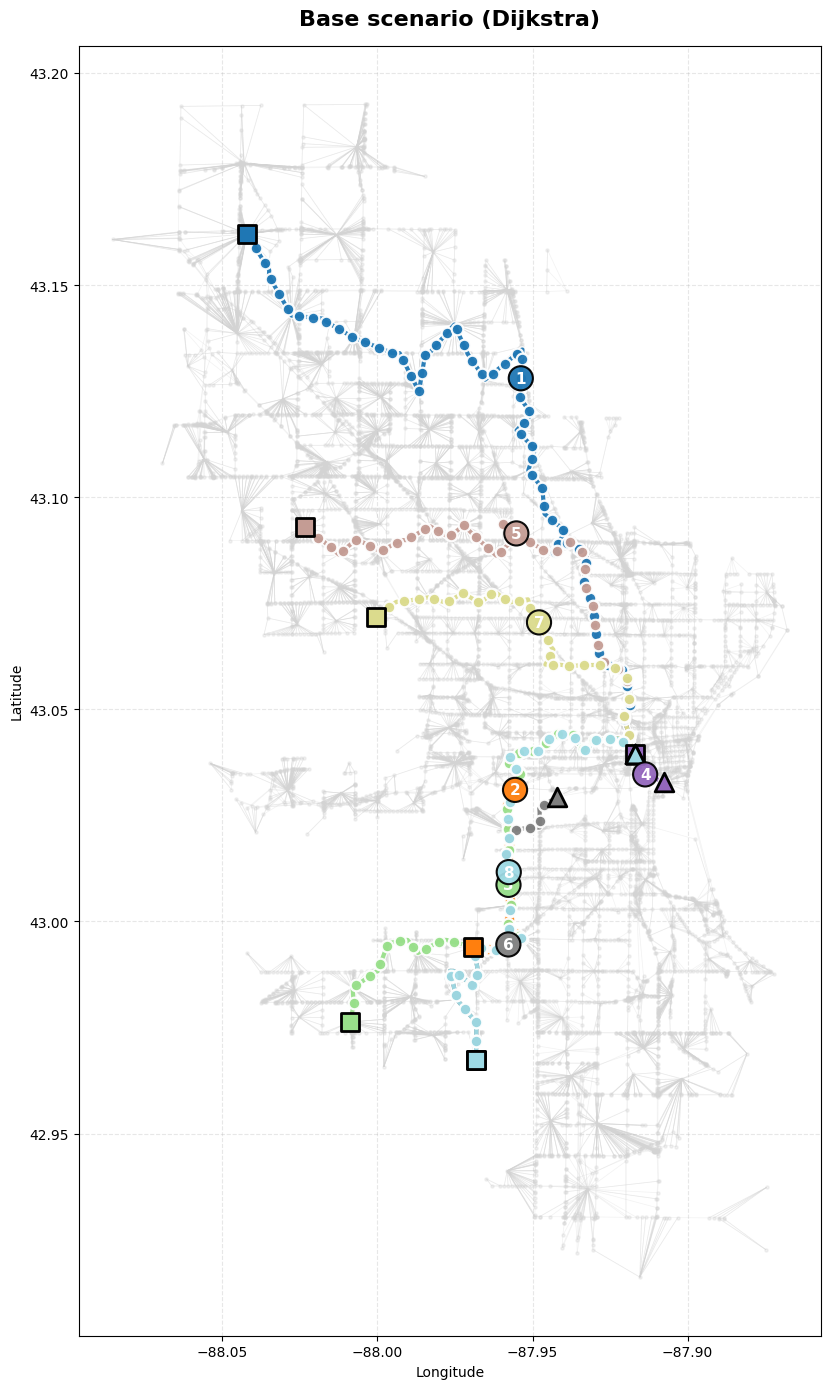

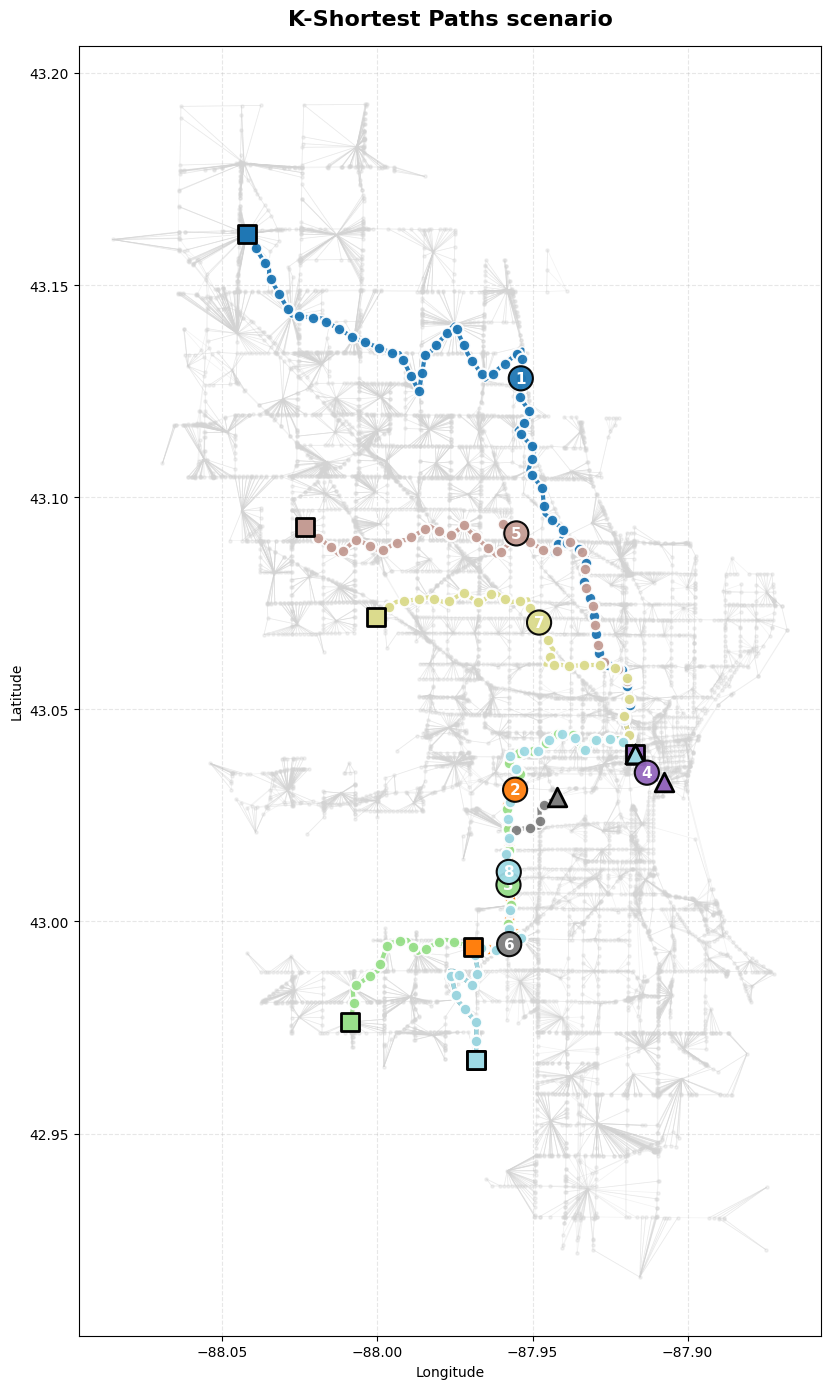

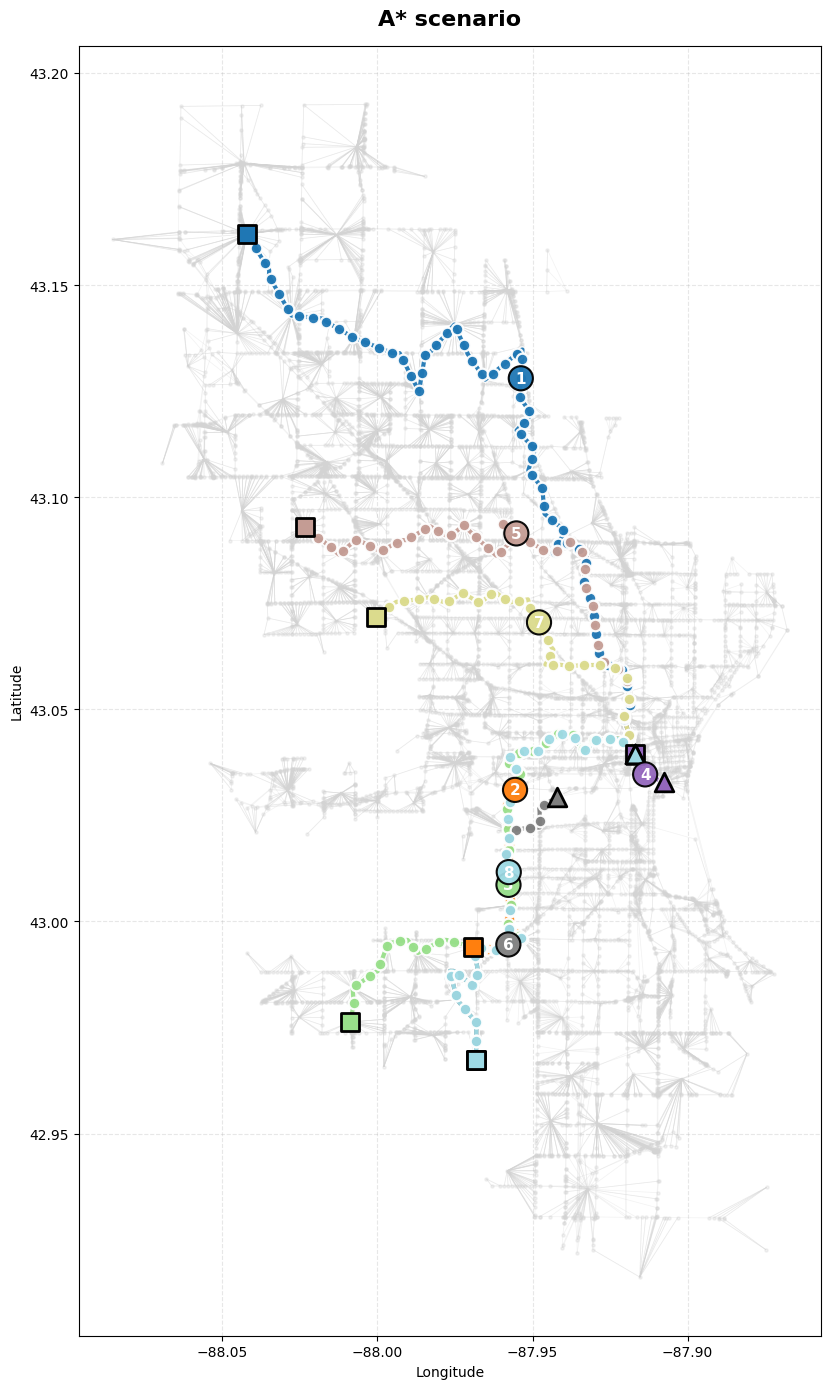

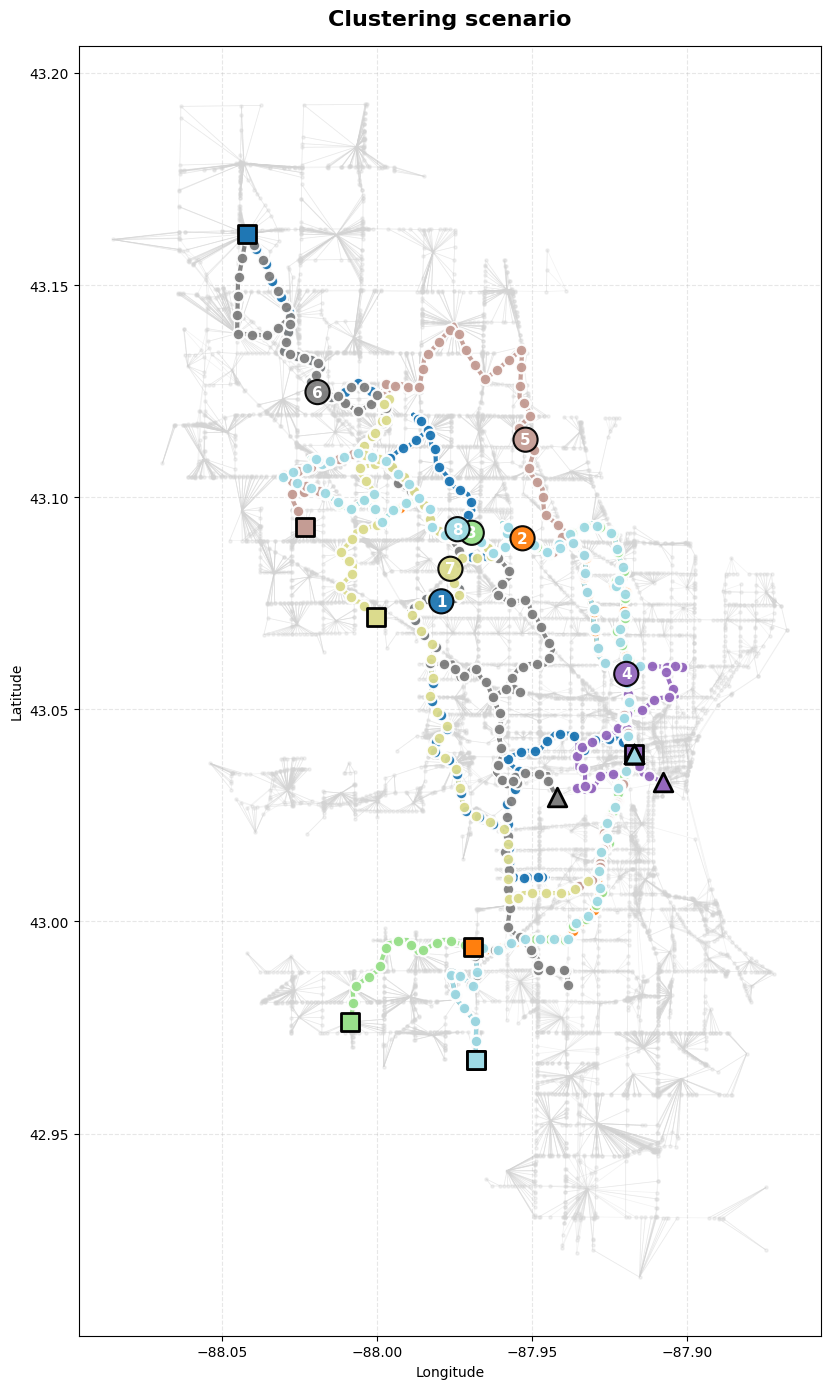

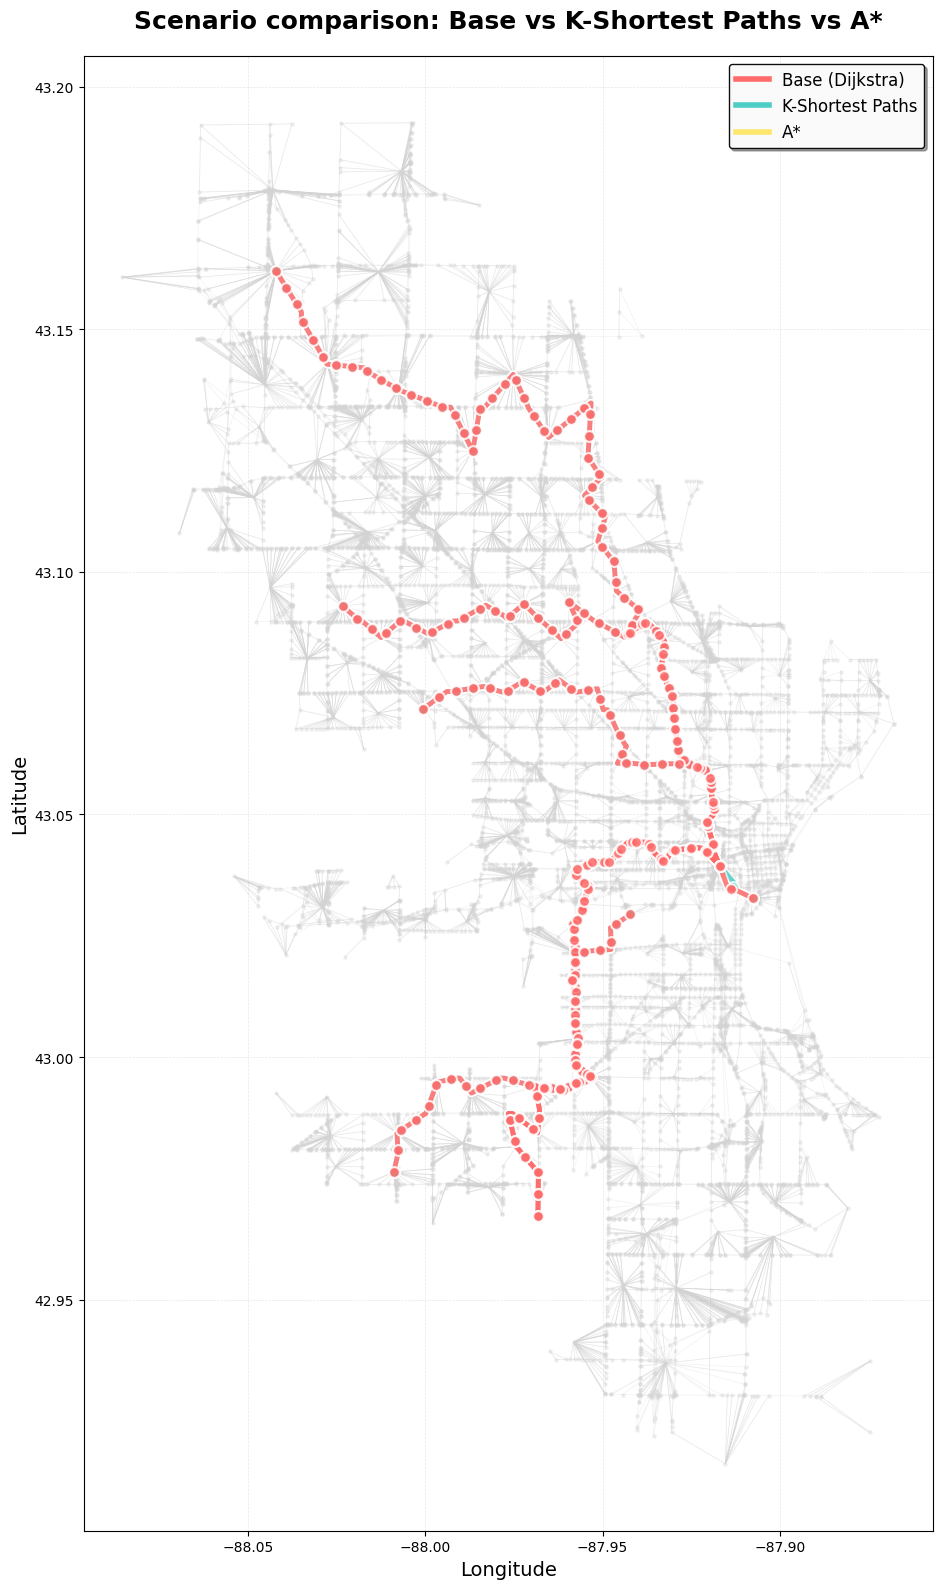

✅ Comparative map generated.


In [ ]:
# Base scenario (Dijkstra)
corridors_base = corridors_catchment
print(f"✅ Base scenario (Dijkstra): {len(corridors_base)} lines.")

# K-Shortest Paths scenario
corridors_k_paths = create_lines_k_shortest_paths(
    corridors_catchment, G, nodes_gdf, stop_spacing_m, kth=3
)
print(f"✅ K-Shortest Paths scenario: {len(corridors_k_paths)} lines.")

# Cache node coordinates for the heuristic
node_xy = {}
for _, row in nodes_gdf.iterrows():
    geom = parse_geometry(row.geometry)
    node_xy[row['node_id']] = (geom.x, geom.y)

# A* scenario
corridors_astar = create_lines_astar_custom(
    corridors_catchment, G, nodes_gdf, stop_spacing_m
)
print(f"✅ A* scenario: {len(corridors_astar)} lines.")

# Clustering scenario
corridors_cluster = create_lines_clustering(
    corridors_catchment, G, nodes_gdf, zone_points_gdf, df_demand, stop_spacing_m,
    n_clusters=2, top_zones=8
)
print(f"✅ Clustering scenario: {len(corridors_cluster)} lines.")

# Visualize scenarios
plot_scenario(corridors_base, "Base scenario (Dijkstra)")
plot_scenario(corridors_k_paths, "K-Shortest Paths scenario")
plot_scenario(corridors_astar, "A_star scenario")
plot_scenario(corridors_cluster, "Clustering scenario")

# Comparative map
fig, ax = plt.subplots(figsize=(20, 16))
links_gdf.plot(ax=ax, color='lightgray', linewidth=0.5, alpha=0.3, zorder=1)
nodes_gdf.plot(ax=ax, color='lightgray', markersize=5, alpha=0.3, zorder=2)

colors_methods = {
    'Base': '#FF6B6B',
    'K-Shortest': '#4ECDC4',
    'A*': '#FFE66D'
}

methods_to_plot = [
    ('A*', corridors_astar, colors_methods['A*'], 3),
    ('K-Shortest', corridors_k_paths, colors_methods['K-Shortest'], 4),
    ('Base', corridors_base, colors_methods['Base'], 5)
]

for method_name, corridors, color, zorder in methods_to_plot:
    for i, corr in enumerate(corridors, start=1):
        line_gdf = gpd.GeoDataFrame([{'geometry': corr['geometry']}], crs='EPSG:4326')
        stops_gdf = gpd.GeoDataFrame(geometry=corr['stops'], crs='EPSG:4326')

        line_gdf.plot(ax=ax, color='white', linewidth=6, alpha=0.7, zorder=zorder)
        line_gdf.plot(ax=ax, color=color, linewidth=3.5, alpha=0.85, zorder=zorder+1, label=method_name if i == 1 else "")
        stops_gdf.plot(ax=ax, color=color, markersize=60, alpha=0.85,
                      edgecolor='white', linewidth=1.5, marker='o', zorder=zorder+2)

ax.set_title('Scenario comparison: Base vs K-Shortest Paths vs A*',
            fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=colors_methods['Base'], linewidth=4, label='Base (Dijkstra)'),
    Line2D([0], [0], color=colors_methods['K-Shortest'], linewidth=4, label='K-Shortest Paths'),
    Line2D([0], [0], color=colors_methods['A*'], linewidth=4, label='A*')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12, framealpha=0.95,
         edgecolor='black', fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig('../results/bus/scenario_comparison.png', dpi=300)
plt.show()
print("✅ Comparative map generated.")


---
### **11. Custom Network**
**Objective**: Create a custom network by selecting and merging lines from previous scenarios.


✅ Custom network created with 6 lines:
  Line 1: Zone 220 → Zone 67 | Length: 34350.57 m
  Line 2: Zone 190 → Zone 67 | Length: 21481.95 m
  Line 3: Zone 67 → Zone 49 | Length: 1617.26 m
  Line 4: Zone 206 → Zone 67 | Length: 21579.58 m
  Line 5: Zone 193 → Zone 67 | Length: 14890.61 m
  Line 6: Zone 82 → Zone 67 | Length: 20725.76 m


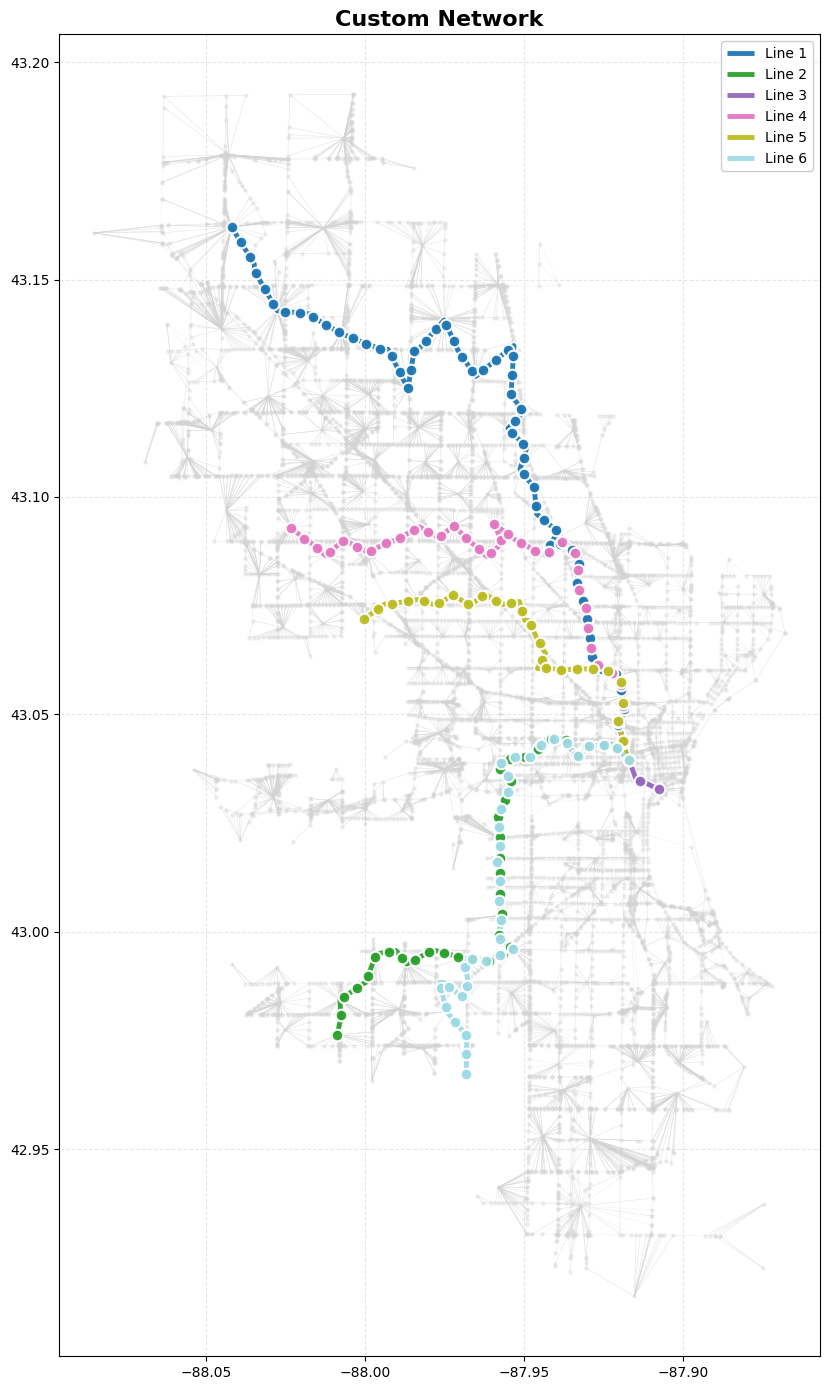

In [ ]:
def reverse_corridor(corr):
    """Reverse a corridor (geometry and stops)."""
    geom_rev = LineString(list(corr['geometry'].coords)[::-1])
    stops_rev = corr['stops'].iloc[::-1].reset_index(drop=True)
    path_rev = list(corridor.get('path_nodes', []))[::-1] if 'path_nodes' in corr else []
    out = corr.copy()
    out['geometry'] = geom_rev
    out['stops'] = stops_rev
    if path_rev:
        out['path_nodes'] = path_rev
    out['o_zone'], out['d_zone'] = corr['d_zone'], corr['o_zone']
    return out

def fuse_corridors(c1, c2):
    """Merge two corridors."""
    coords1 = list(c1['geometry'].coords)
    coords2 = list(c2['geometry'].coords)
    coords = coords1 + (coords2[1:] if coords1[-1] == coords2[0] else coords2)
    geom = LineString(coords)
    stops1 = list(c1['stops'])
    stops2 = list(c2['stops'])
    stops = stops1 + (stops2[1:] if stops1[-1] == stops2[0] else stops2)
    stops_gs = gpd.GeoDataFrame(stops, crs='EPSG:4326', geometry='geometry')
    geom_proj = gpd.GeoSeries([geom], crs='EPSG:4326').to_crs(3857).iloc[0]
    return {
        'o_zone': c1['o_zone'],
        'd_zone': c2['d_zone'],
        'geometry': geom,
        'stops': stops_gs,
        'length_m': geom_proj.length,
    }

# Select lines 1, 3, 4, 5, 7, and 8 from the base scenario
# Note: Python uses zero-based indexing, so line 1 is index 0, line 2 is index 1, etc.
selected_indices = [0, 2, 3, 4, 6, 7]  # Indices for lines 1, 3, 4, 5, 7, and 8
selected_base_lines = [corridors_base[i] for i in selected_indices if i < len(corridors_base)]

# Create the custom network
custom_network = selected_base_lines

print(f"✅ Custom network created with {len(custom_network)} lines:")
for i, line in enumerate(custom_network):
    name = f'Line {i+1}'
    print(f"  {name}: Zone {line['o_zone']} → Zone {line['d_zone']} | Length: {line['length_m']:.2f} m")

# Visualize the custom network
def plot_custom_network(net):
    colors = plt.cm.tab20(np.linspace(0, 1, len(net)))
    fig, ax = plt.subplots(figsize=(18, 14))
    links_gdf.plot(ax=ax, color='lightgray', linewidth=0.4, alpha=0.3, zorder=1)
    nodes_gdf.plot(ax=ax, color='lightgray', markersize=5, alpha=0.3, zorder=2)

    for corr, color in zip(net, colors):
        line_gdf = gpd.GeoDataFrame([{'geometry': corr['geometry']}], crs='EPSG:4326')
        stops_gdf = gpd.GeoDataFrame(geometry=corr['stops'], crs='EPSG:4326')

        line_gdf.plot(ax=ax, color='white', linewidth=6, alpha=0.8, zorder=4)
        line_gdf.plot(ax=ax, color=color, linewidth=3.5, alpha=0.95, zorder=5, label=f'Line {net.index(corr)+1}')
        stops_gdf.plot(ax=ax, color=color, markersize=70, alpha=0.95,
                      edgecolor='white', linewidth=1.5, marker='o', zorder=6)

    ax.set_title('Custom Network', fontsize=16, fontweight='bold')
    ax.legend(loc='upper right', framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('../results/bus/custom_network.png', dpi=300)
    plt.show()

plot_custom_network(custom_network)

---
### **12. Detailed Network Analysis**
**Objective**: Analyze network statistics (length, ridership, number of stops).


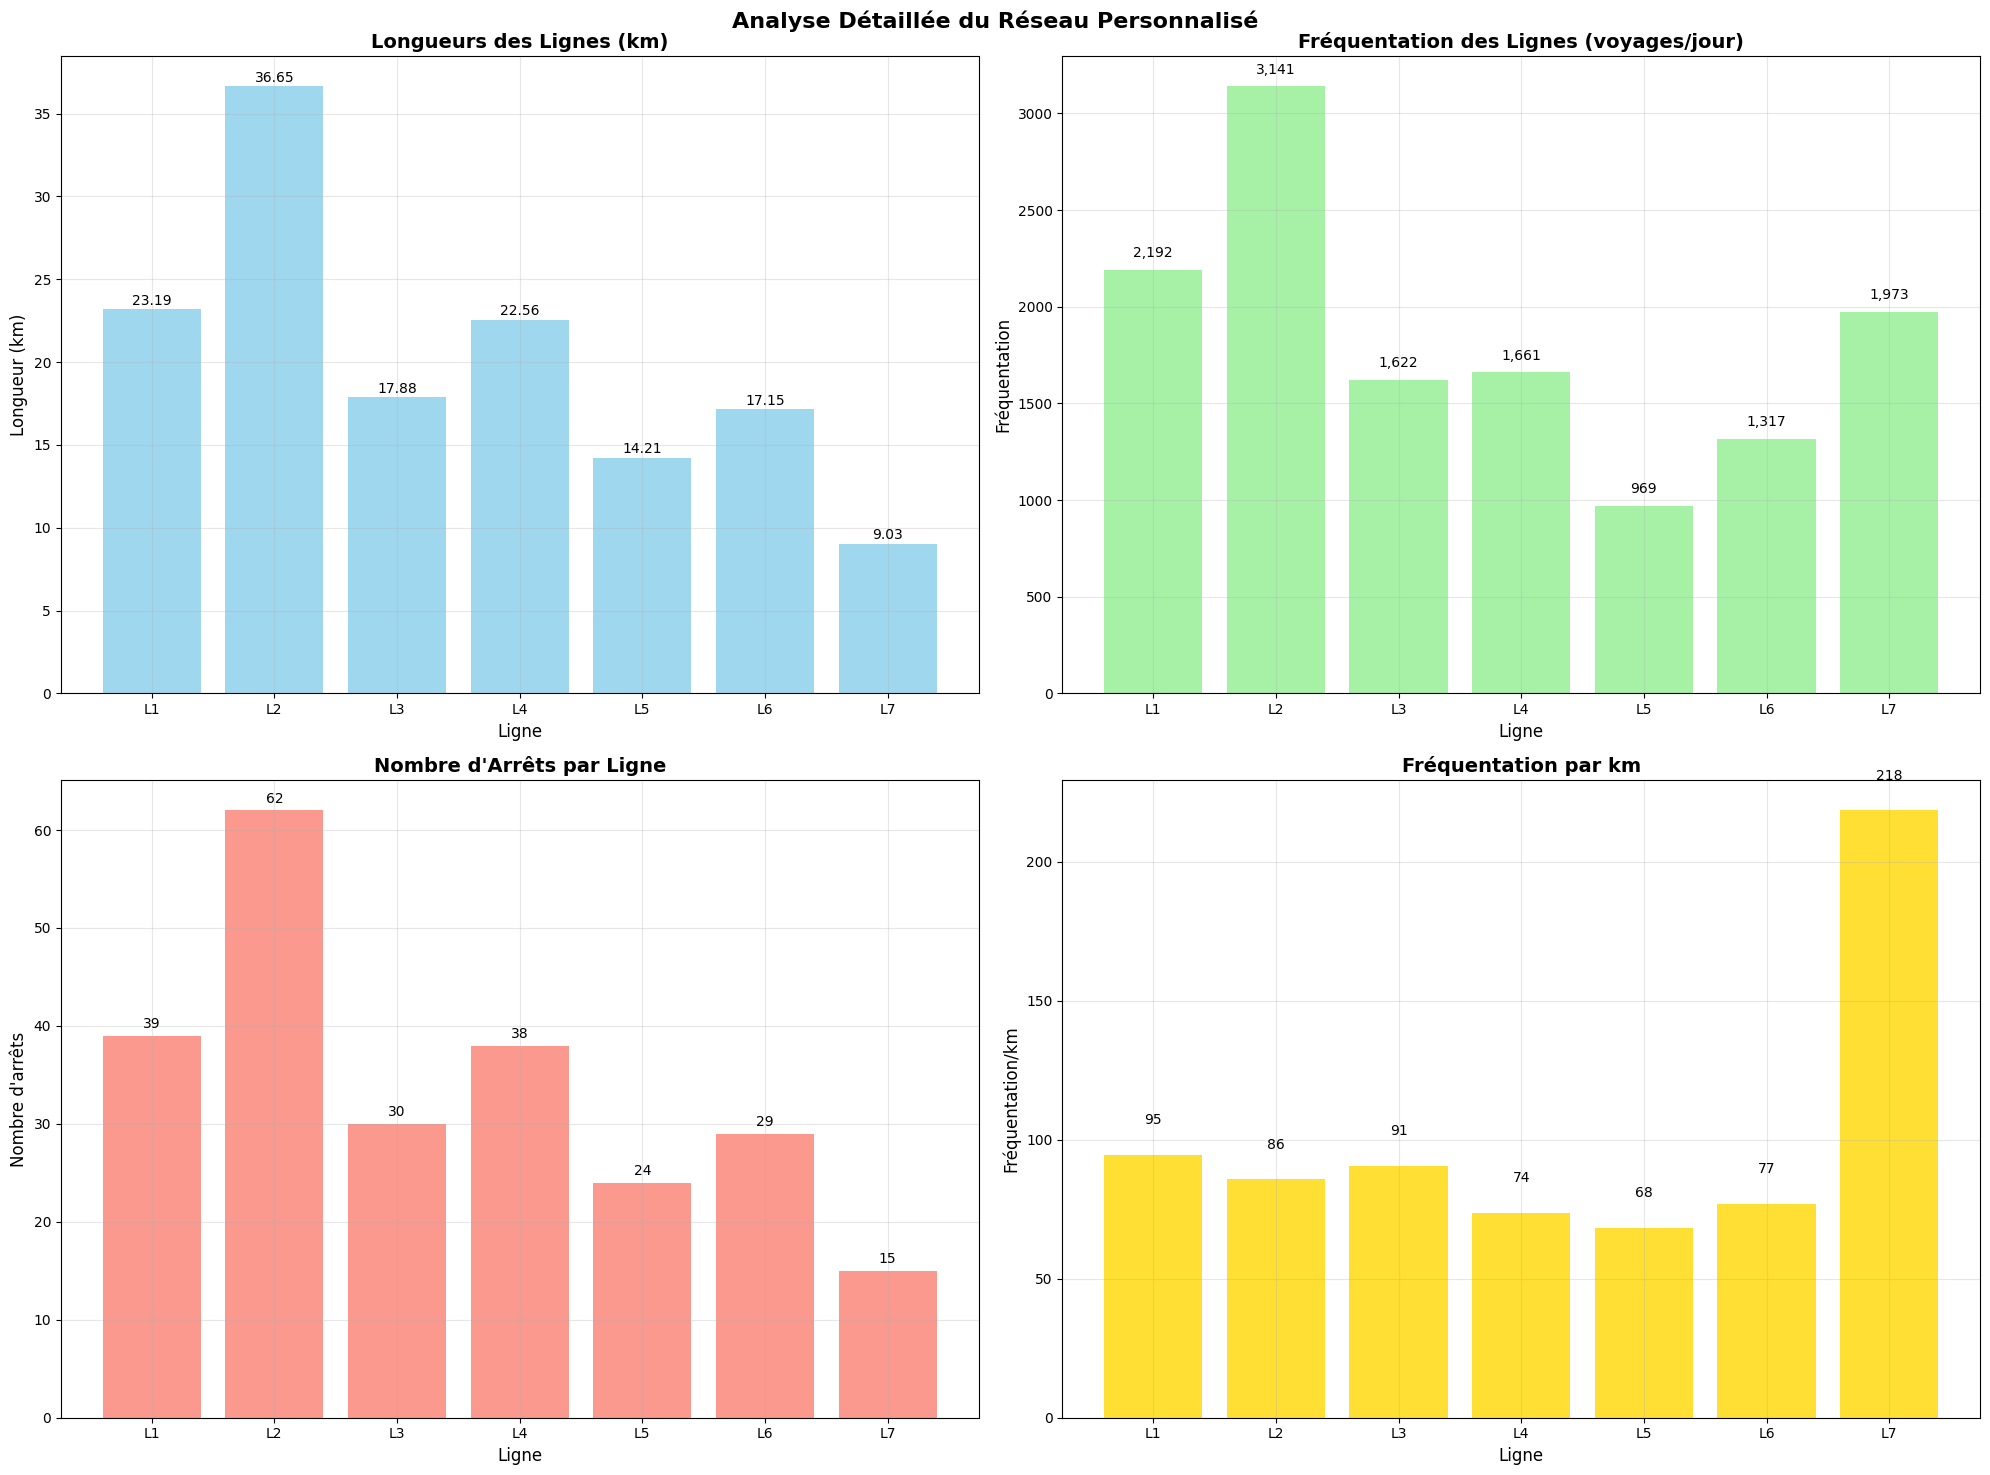

In [ ]:
def plot_network_stats(network):
    """Visualize statistics of the custom network."""
    lengths_km = [corridor['length_m'] / 1000 for corridor in network]
    riderships = [calculate_line_ridership(corridor, 400) for corridor in network]
    stops_count = [len(corridor['stops']) for corridor in network]
    ridership_per_km = [riderships[i] / lengths_km[i] for i in range(len(network))]

    fig, axes = plt.subplots(2, 2, figsize=(20, 15))

    # Line lengths
    ax1 = axes[0, 0]
    bars1 = ax1.bar(range(len(network)), lengths_km, color='skyblue', alpha=0.8)
    ax1.set_title('Line lengths (km)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Line', fontsize=12)
    ax1.set_ylabel('Length (km)', fontsize=12)
    ax1.set_xticks(range(len(network)))
    ax1.set_xticklabels([f'L{i+1}' for i in range(len(network))])
    ax1.grid(True, alpha=0.3)
    for i, bar in enumerate(bars1):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{lengths_km[i]:.2f}', ha='center', va='bottom', fontsize=10)

    # Line ridership
    ax2 = axes[0, 1]
    bars2 = ax2.bar(range(len(network)), riderships, color='lightgreen', alpha=0.8)
    ax2.set_title('Line ridership (trips/day)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Line', fontsize=12)
    ax2.set_ylabel('Ridership', fontsize=12)
    ax2.set_xticks(range(len(network)))
    ax2.set_xticklabels([f'L{i+1}' for i in range(len(network))])
    ax2.grid(True, alpha=0.3)
    for i, bar in enumerate(bars2):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                f'{riderships[i]:,}', ha='center', va='bottom', fontsize=10)

    # Number of stops per line
    ax3 = axes[1, 0]
    bars3 = ax3.bar(range(len(network)), stops_count, color='salmon', alpha=0.8)
    ax3.set_title('Number of stops per line', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Line', fontsize=12)
    ax3.set_ylabel('Number of stops', fontsize=12)
    ax3.set_xticks(range(len(network)))
    ax3.set_xticklabels([f'L{i+1}' for i in range(len(network))])
    ax3.grid(True, alpha=0.3)
    for i, bar in enumerate(bars3):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{stops_count[i]}', ha='center', va='bottom', fontsize=10)

    # Ridership per km
    ax4 = axes[1, 1]
    bars4 = ax4.bar(range(len(network)), ridership_per_km, color='gold', alpha=0.8)
    ax4.set_title('Ridership per km', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Line', fontsize=12)
    ax4.set_ylabel('Ridership/km', fontsize=12)
    ax4.set_xticks(range(len(network)))
    ax4.set_xticklabels([f'L{i+1}' for i in range(len(network))])
    ax4.grid(True, alpha=0.3)
    for i, bar in enumerate(bars4):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                f'{ridership_per_km[i]:.0f}', ha='center', va='bottom', fontsize=10)

    plt.suptitle('Detailed analysis of the custom network', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('../results/bus/custom_network_stats.png', dpi=300)
    plt.show()

plot_network_stats(custom_network)
print("✅ Detailed analysis of the custom network generated.")
